# Convolutional Neural Networks - Classifying Brain MR Images

The objective of this demo is to illustrate how to use Convolutional Neural Networks (CNNs) for classification and regression problems usin a real dataset.

You can use this dataset for:
- Gender prediction
- Age prediction
- MR scanner vendor prediction
- MR scanner magnetic field prediction

Data download link: https://drive.google.com/drive/folders/13zrjRzrOGv10X9W8z_uq-AuGqnxzuqS5?usp=sharing

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Loading the data using the Keras function
X = np.load("../Data/CC-359/images.npy")
age = np.load("../Data/CC-359/age.npy")
vendor = np.load("../Data/CC-359/vendor.npy")
field = np.load("../Data/CC-359/field.npy")
gender = np.load("../Data/CC-359/gender.npy")


print("Development set")
print("Images: ",X.shape)
print("\nClasses:",np.sort(np.unique(age)))
print("\nClasses:",np.unique(vendor))
print("\nClasses:",np.unique(field))
print("\nClasses:",np.unique(gender))

Development set
Images:  (7180, 193, 229)

Classes: [29 31 34 36 37 38 39 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 69 71 80]

Classes: ['g' 'p' 's']

Classes: ['1' '3']

Classes: ['F' 'M']


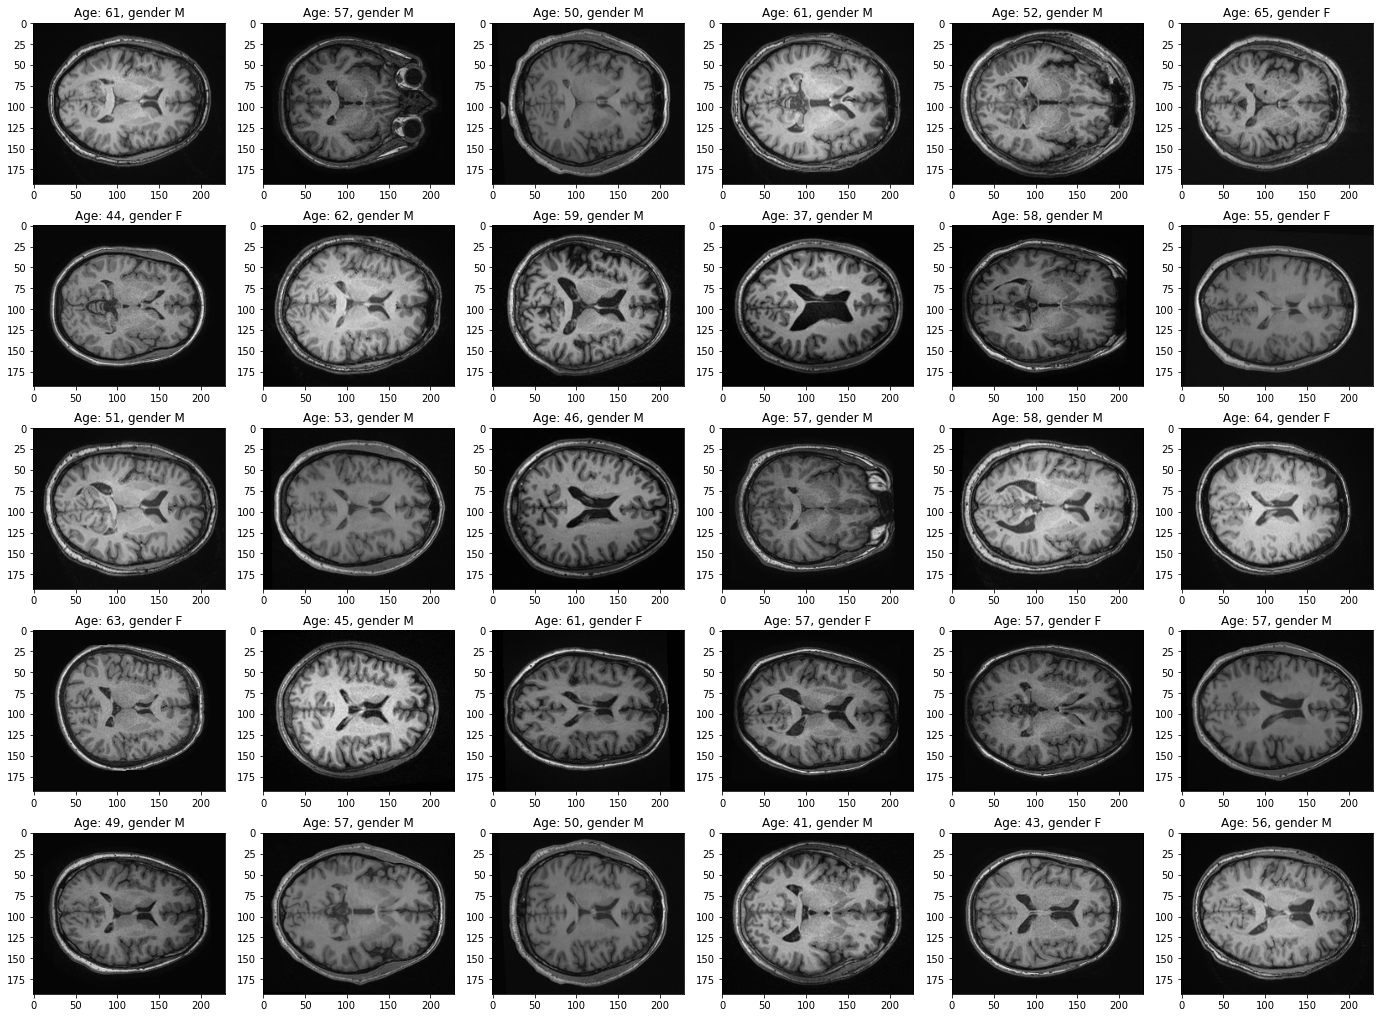

In [3]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X[jj], cmap = "gray")
    plt.title("Age: %d, gender %s" %(age[jj],gender[jj]))
plt.show()

In [4]:
# Each subject has 20 images and they are sorted sequentially in the data. When splitting the data, we shouldn't
# contaminate train/val/test
indexes = np.arange(359, dtype = int)
np.random.shuffle(indexes)
nslices = 20
train = indexes[:int(0.6*indexes.shape[0])]*nslices
train = np.repeat(train,nslices).reshape(-1,nslices) + np.arange(nslices)# 60%
val = indexes[int(0.6*indexes.shape[0]):int(0.8*indexes.shape[0])]*nslices # 20%
val = np.repeat(val,nslices).reshape(-1,nslices) + np.arange(nslices)
test = indexes[int(0.8*indexes.shape[0]):]*nslices # 20%
test = np.repeat(test,nslices).reshape(-1,nslices) + np.arange(nslices)
train = train.flatten()
val = val.flatten()
test = test.flatten()

In [5]:
# Train and validation split
X_train = X[train]
Y_train = (gender[train] == 'M')
Y_train_age = age[train]
X_val = X[val]
Y_val = (gender[val] == 'M')
Y_val_age = age[val]
X_test = X[test]
Y_test = (gender[test] == 'M')
Y_test_age = age[test]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (4300, 193, 229)
Labels shape:  (4300,)

Validation set
Images:  (1440, 193, 229)
Labels shape:  (1440,)


In [6]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0.0 1.0 0.1785403188225346 0.14332718415026877
0.0 1.0 0.17512439832033752 0.13900190198553167


In [13]:
ishape = (193,229,1)
k = 2 # gender classification
lr = 1e-3
model_input = tf.keras.layers.Input(shape = ishape)
l1 = tf.keras.layers.Conv2D(48, (3,3), activation='relu')(model_input)
l2 = tf.keras.layers.Conv2D(48, (3,3),  activation='relu')(l1)
l2_drop = tf.keras.layers.Dropout(0.3)(l2)
l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)

l4 = tf.keras.layers.Conv2D(96, (3,3),  activation='relu')(l3)
l5 = tf.keras.layers.Conv2D(96, (3,3),  activation='relu')(l4)
l5_drop = tf.keras.layers.Dropout(0.5)(l5)
l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)

l7 = tf.keras.layers.Conv2D(192, (3,3),  activation='relu')(l6)
l8 = tf.keras.layers.Conv2D(192, (3,3),  activation='relu')(l7)
l8_drop = tf.keras.layers.Dropout(0.5)(l8)
l9 = tf.keras.layers.MaxPool2D((2,2))(l8_drop)

l10 = tf.keras.layers.Conv2D(384, (3,3),  activation='relu')(l9)
l11 = tf.keras.layers.Conv2D(384, (3,3),  activation='relu')(l10)
l11_drop = tf.keras.layers.Dropout(0.3)(l11)


flat = tf.keras.layers.Flatten()(l11_drop)

out = tf.keras.layers.Dense(1,activation = 'sigmoid')(flat)

model = tf.keras.models.Model(inputs = model_input, outputs = out)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = "binary_crossentropy", metrics = ["accuracy"])

In [15]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 193, 229, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 191, 227, 48)      480       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 189, 225, 48)      20784     
_________________________________________________________________
dropout_5 (Dropout)          (None, 189, 225, 48)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 94, 112, 48)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 92, 110, 96)       41568     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 108, 96)       8304

In [16]:
model_name = "best_model_cc359_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
model.fit(X_train[:,:,:,np.newaxis],Y_train,batch_size = 64, epochs = 25, \
          verbose = 1, callbacks= [early_stop, monitor],validation_data=(X_val[:,:,:,np.newaxis],Y_val), shuffle  = True)

Epoch 1/25
68/68 [==============================] - 17s 241ms/step - loss: 0.7325 - accuracy: 0.5088 - val_loss: 0.6959 - val_accuracy: 0.4583
Epoch 2/25
68/68 [==============================] - 15s 222ms/step - loss: 0.6929 - accuracy: 0.5192 - val_loss: 0.6956 - val_accuracy: 0.4583
Epoch 3/25
68/68 [==============================] - 16s 230ms/step - loss: 0.6869 - accuracy: 0.5481 - val_loss: 0.6466 - val_accuracy: 0.6778
Epoch 4/25
68/68 [==============================] - 15s 222ms/step - loss: 0.4287 - accuracy: 0.8043 - val_loss: 0.4588 - val_accuracy: 0.7681
Epoch 5/25
68/68 [==============================] - 15s 219ms/step - loss: 0.2898 - accuracy: 0.8748 - val_loss: 0.6700 - val_accuracy: 0.6382
Epoch 6/25
68/68 [==============================] - 15s 223ms/step - loss: 0.1875 - accuracy: 0.9181 - val_loss: 0.4386 - val_accuracy: 0.7694
Epoch 7/25
68/68 [==============================] - 15s 221ms/step - loss: 0.1193 - accuracy: 0.9553 - val_loss: 0.4081 - val_accuracy: 0.7993

In [ ]:
model.load_weights(model_name)
metrics = model.evaluate(X_test[:,:,:,np.newaxis],Y_test)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

In [ ]:
Ypred = model.predict(X_test[:,:,:,np.newaxis]) > 0.5
Ypred = Ypred.reshape(-1,nslices).mean(axis = 1) > 0.5

print((Ypred == Y_test[::20]).sum()/Ypred.size)